In [1]:
import os
#output appears below cells, don't need plt.show every time
%matplotlib inline
from pprint import pprint
import numpy as np
import astropy.io
from astropy.io import fits
import glob
from astropy.stats import mad_std
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc as ccdp
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
#for 2023_02_23 data, calibration frames from 2023_01_23 are used

luminance = 'Flat_Luminance_6_secs_master.fits'
red = 'Flat_Red_0.092_secs_master.fits'
green = 'Flat_Green_0.054_secs_master.fits'
blue = 'Flat_Blue_0.069_secs_master.fits'

#read in some light frames (MUST BE SAME KIND AS MASTER FLAT FRAME!!!!!!)
#set the current file we are looking at based on filter, can be either Luminance, Red, Green or Blue
current_filter = 'Luminance'
flat_name = luminance

#set the path to the current file we are looking at
current_raw_path = f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Lights/{current_filter}/'

#create a list of files in the directory (file) indicated by the path, just in case some sub folders exist or files that are
#not of the FITS type. Exclude a corrupted file.
file_list = [f for f in os.listdir(current_raw_path) if f.endswith('.fits')]
#and f != 'star_Light_Luminance_10_secs_051.fits'

#convert the path from a string into a Path object that can be put into functions
raw_path = Path(current_raw_path)

#read in the images
raw_ims = ccdp.ImageFileCollection(raw_path, filenames=file_list)

#define path for new reduced files to be written to
file_path = Path(f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Lights/{current_filter} Reduced')

In [3]:
bias_master = CCDData.read('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Bias/Bias_0.000032_secs_master.fits')

dark_master = CCDData.read('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Darks/Dark_45_secs_master.fits')
dark_exptime = dark_master.header['exptime']
dark_exptime_unit = dark_exptime * u.second
dark_master_bias_sub = CCDData.read('./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Darks/Dark_45_secs_master_Bias_Subtracted.fits')

current_flat_path = Path(f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/Flats/{current_filter} Reduced/')
flat_master = CCDData.read(current_flat_path / flat_name)

In [4]:
#reduce the light frames

#iterate over image data and file name in the set of files
for light, file_name in raw_ims.ccds(imagetyp='Light Frame', ccd_kwargs={'unit':'adu'}, return_fname=True):
    #read in file header
    header_info = CCDData.read(raw_path / file_name, unit='adu').header
    #save exposure time
    exptime = header_info['exptime']
    #delete the read in file to save memory
    del header_info
    #make a new file name to be associated with the reduced image
    file_name = file_name.replace('.fits', '_reduced.fits')
    print(f'exptime={exptime}')
    #convert image data into the correct data type
    light = CCDData(light, unit='adu')
    
    #filter the operations done on the raw data by exposure time
    if exptime == dark_exptime:
        #subtract the master dark, which also serves to remove the bias
        reduced = ccdp.subtract_dark(light, dark_master, exposure_time = 'exptime', exposure_unit = u.second)
        
    else:
        #subtract the master bias
        reduced = ccdp.subtract_bias(light, bias_master)

        #scale and subtract the dark with bias removed so it's not subtracted twice
        reduced = ccdp.subtract_dark(reduced, dark_master_bias_sub, dark_exposure=dark_exptime_unit, 
                                     data_exposure=exptime * u.second, exposure_unit=u.second, scale=True)
    
    #subtract the master flat
    reduced = ccdp.flat_correct(reduced, flat_master)
    #print the new file name to check it worked correctly
    print(file_name)
    
    #update header/meta of new light file to include it has been reduced
    reduced.meta['REDUCED'] = True
    #write to new file
    reduced.write(file_path / file_name, overwrite=True)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


exptime=10.0
star_Light_Luminance_10_secs_001_reduced.fits


OSError: Not enough space on disk: requested 278615040, available 700416. Not enough space on disk: requested 131112960, available 700416. 16389120 requested and 0 written

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Text(0, 0.5, 'Pixel Number')

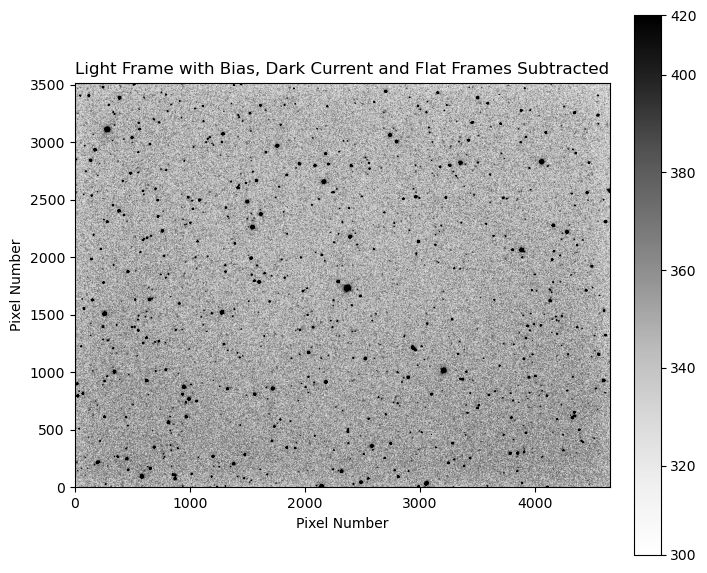

In [5]:
#read in reduced file and its associated raw file
lum_ccd = CCDData.read('./RZ Cep/2023_1_23/RZ_Cep/Light/Luminance/star_Light_Luminance_15_secs_017.fits', unit='adu')
reduced_lum = CCDData.read('./RZ Cep/2023_1_23/RZ_Cep/Light/Luminance Reduced/star_Light_Luminance_15_secs_017_reduced.fits', unit='adu')

#plot example raw and reduced light frames to show the data reduction works
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

show_image(reduced_lum.data, cmap='Greys')
plt.title('Light Frame with Bias, Dark Current and Flat Frames Subtracted')
plt.xlabel('Pixel Number')
plt.ylabel('Pixel Number')
#show_image(reduced_lum.data, cmap='BuPu_r', ax=ax2, fig=fig)
#ax2.set_title('Light frame with Bias, Dark Current and Flat Frame Subtracted')

In [6]:
#tests that header wrote to file and updated correctly
reduced_lum.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4656                                                  
NAXIS2  =                 3520                                                  
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ROWORDER= 'TOP-DOWN'           / Row Order                                      
INSTRUME= 'ZWO CCD ASI1600MM Pro' / CCD Name                                    
TELESCOP= 'SynScan '           / Telescope name                                 
OBSERVER= 'Unknown '           / Observer name                                  
OBJECT  = 'star    '        

In [4]:
from astropy import visualization as aviz
from astropy.nddata.blocks import block_reduce
from astropy.nddata.utils import Cutout2D


def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriate stretching.

    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)